In [23]:
import numpy as np
import pandas as pd

Load Travis' table

In [48]:
tb = pd.read_csv("../../data/All_KepStars_For_Ruth_McQuillan_Analysis_grJHK.csv")

In [49]:
tb.head()

,KIC,source_id,plx,plxe,g_final,g_final_err,g_prov_final,r_final,r_final_err,r_prov_final,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,[Fe/H]i,n_[Fe/H]i,_RA,_DE
0,757076,2050233807328471424,0.001524,0.000048,12.350957,0.020306,g_kic_fixed,11.588633,0.020419,r_kic_fixed,10.126,0.018,9.667,0.019,9.559,0.017,-0.083,KIC,291.03873,36.59813
1,757099,2050233601176543104,0.002708,0.000027,13.704047,0.020015,g_kis_fixed,13.115469,0.020004,r_kis_fixed,11.656,0.018,11.193,0.019,11.094,0.018,-0.208,KIC,291.04306,36.59381
2,757137,2050230543159814656,0.001753,0.000025,10.052258,0.027917,g_kic_fixed,9.099976,0.035228,r_kic_fixed,7.467,0.027,6.853,0.018,6.722,0.017,-0.079,KIC,291.05588,36.55995
3,757280,2050230611879323904,0.001214,0.000022,12.132906,0.020044,g_kic_fixed,11.825413,0.020076,r_kic_fixed,10.852,0.018,10.662,0.018,10.627,0.018,-0.231,KIC,291.09540,36.56494
4,757450,2050231848829944320,0.001199,0.000026,15.894970,0.020246,g_kis_fixed,15.152545,0.020081,r_kis_fixed,13.665,0.021,13.262,0.025,13.118,0.029,0.229,SPE,291.13760,36.57738


Crossmatch with the McQuillan catalogue.

In [50]:
url = "https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt"
mc = pd.read_csv(url)
mc.head()

,KID,Teff,logg,Mass,Prot,Prot_err,Rper,LPH,w,DC,Flag
0,892376,3813,4.47,0.4699,1.532,0.007,7306.69,0.823,0.4503,0,---
1,1026146,4261,4.57,0.6472,14.891,0.120,11742.56,1.405,0.7229,0,---
2,1026474,4122,4.56,0.5914,1.569,0.006,30471.80,1.204,0.6061,0,---
3,1162635,3760,4.77,0.4497,15.678,0.019,10207.47,0.978,0.5445,1,---
4,1164102,4045,4.62,0.5606,31.496,0.474,5139.74,0.568,0.3939,0,---


In [52]:
mctb = pd.merge(tb, mc, left_on="KIC", right_on="KID", how="inner")
print(np.shape(tb), np.shape(mc), np.shape(mctb))

(177039, 20) (34030, 11) (30086, 31)


Calculate Av

In [28]:
from astropy.coordinates import SkyCoord
from dustmaps.bayestar import BayestarQuery
import astropy.units as units

bayestar = BayestarQuery(max_samples=2, version='bayestar2019')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 25.294 s
  pix_info:   0.569 s
   samples:  12.207 s
      best:   5.803 s
       nan:   0.228 s
      sort:   6.271 s
       idx:   0.216 s


In [29]:
coords = SkyCoord(mctb._RA.values*units.deg, mctb._DE.values*units.deg,
                  distance=(1./mctb.plx.values)*units.pc, frame='galactic')

ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.], return_flags=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


(30086, 35) (30086,)
0.00932279979161918


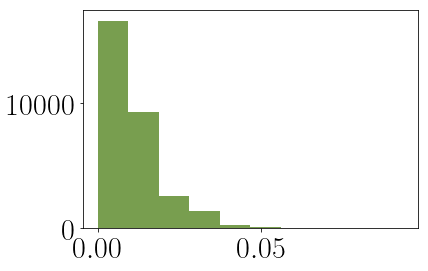

In [86]:
Av_bayestar = 2.742 * ebv
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
Av_std = .5*(Av_errm + Av_errp)
print(np.shape(mctb), np.shape(Av))

plt.hist(Av_errp, alpha=.5);
plt.hist(Av_errm, alpha=.5);
plt.hist(Av_std, alpha=.5)
print(np.median(Av_std))

# Catch places where the extinction uncertainty is zero and default to an uncertainty of .01
m = Av_errp == 0
Av_errp[m] = .01

In [67]:
mctb["Av_flags"] = flags
mctb["Av"] = Av
mctb["Av_errp"] = Av_errp
mctb["Av_errm"] = Av_errm

Remove NaNs.

In [68]:
def mM(m, D):
    return 5 - 5*np.log10(D) + m

m = np.isfinite(mctb.g_final.values - mctb.Kmag.values)
m &= np.isfinite(mM(mctb.g_final.values, 1./mctb.plx.values))
df_finite = mctb.iloc[m]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


Plot stars on the CMD.

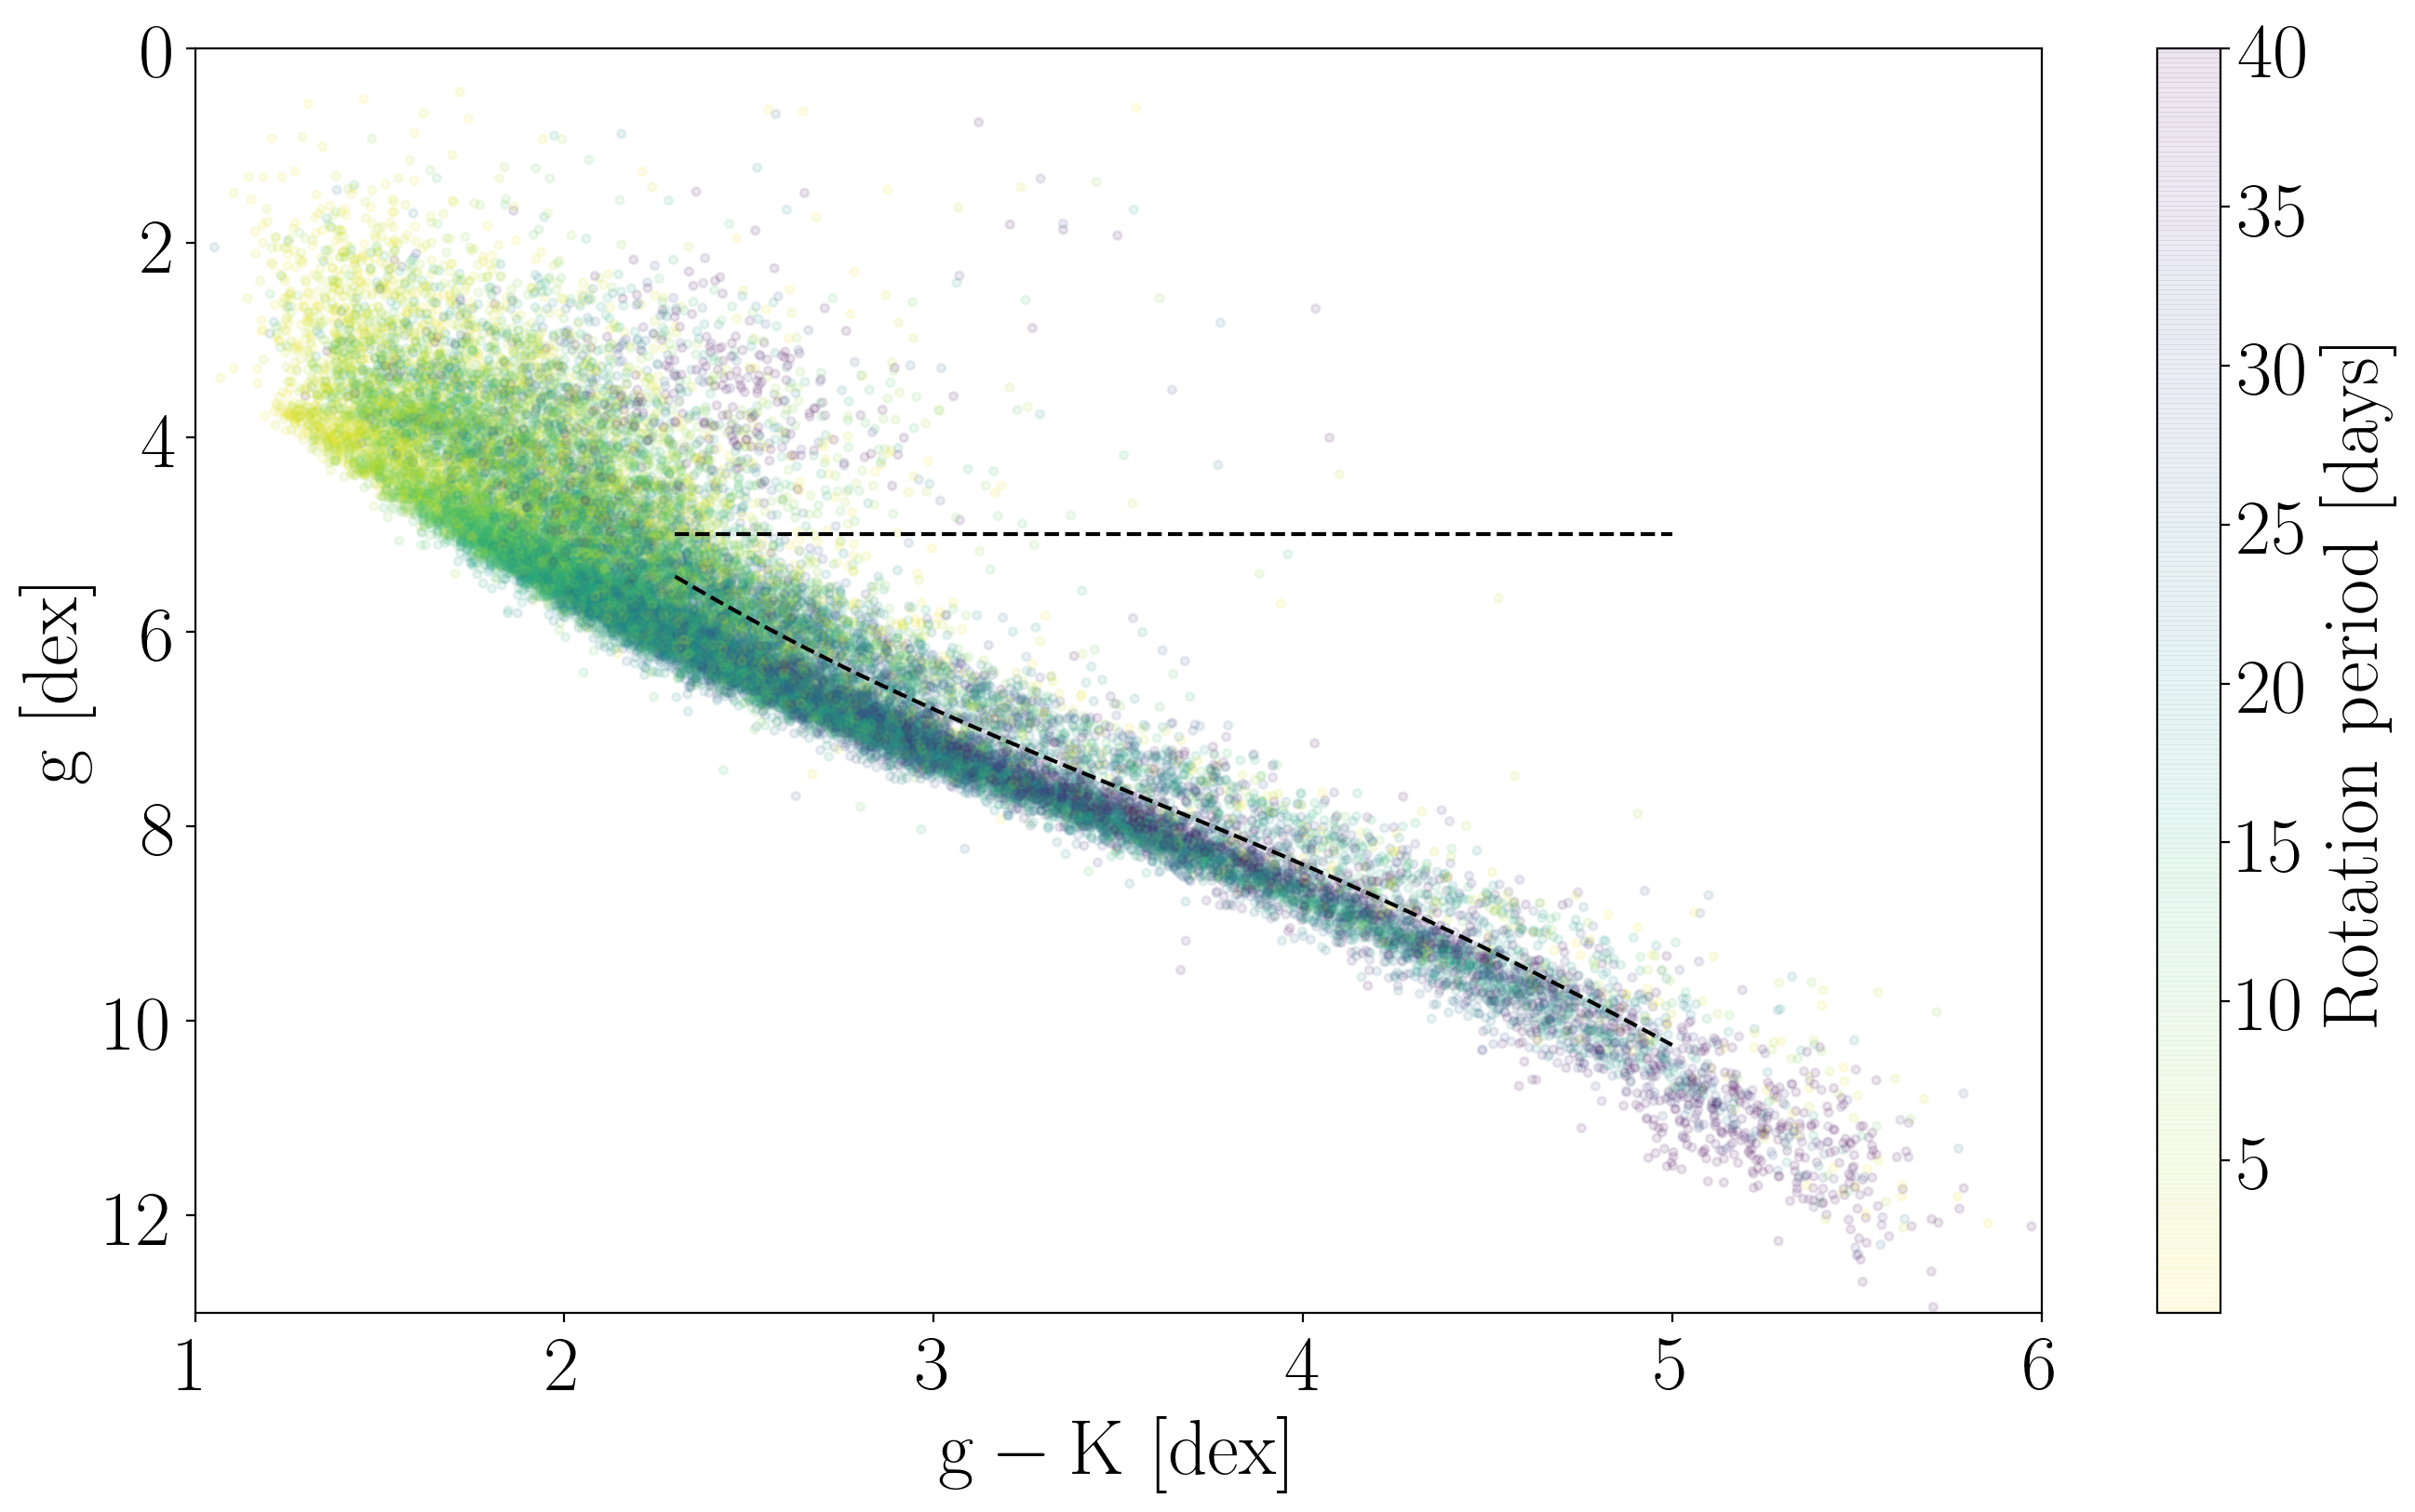

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as spo

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)


plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df_finite.g_final - df_finite.Kmag, mM(df_finite.g_final, 1./df_finite.plx),
            c=df_finite.Prot, s=10, alpha=.1, cmap="viridis_r", vmax=40)
plt.xlabel("$\mathrm{g-K~[dex]}$")
plt.ylabel("$\mathrm{g~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(13, 0)
plt.xlim(1, 6);

x = df_finite.g_final.values - df_finite.Kmag.values
y = mM(df_finite.g_final.values, 1./df_finite.plx.values)

AT = np.vstack((x**6, x**5, x**4, x**3, x**2, x, np.ones_like(x)))
ATA = np.dot(AT, AT.T)
w = np.linalg.solve(ATA, np.dot(AT, y))

minb, maxb, extra = 2.3, 5, .15
xs = np.linspace(minb, maxb, 1000)
plt.plot(xs, np.polyval(w, xs) - extra, "k--")
plt.plot(xs, np.ones_like(xs)*5, "k--")

Cut out the binaries

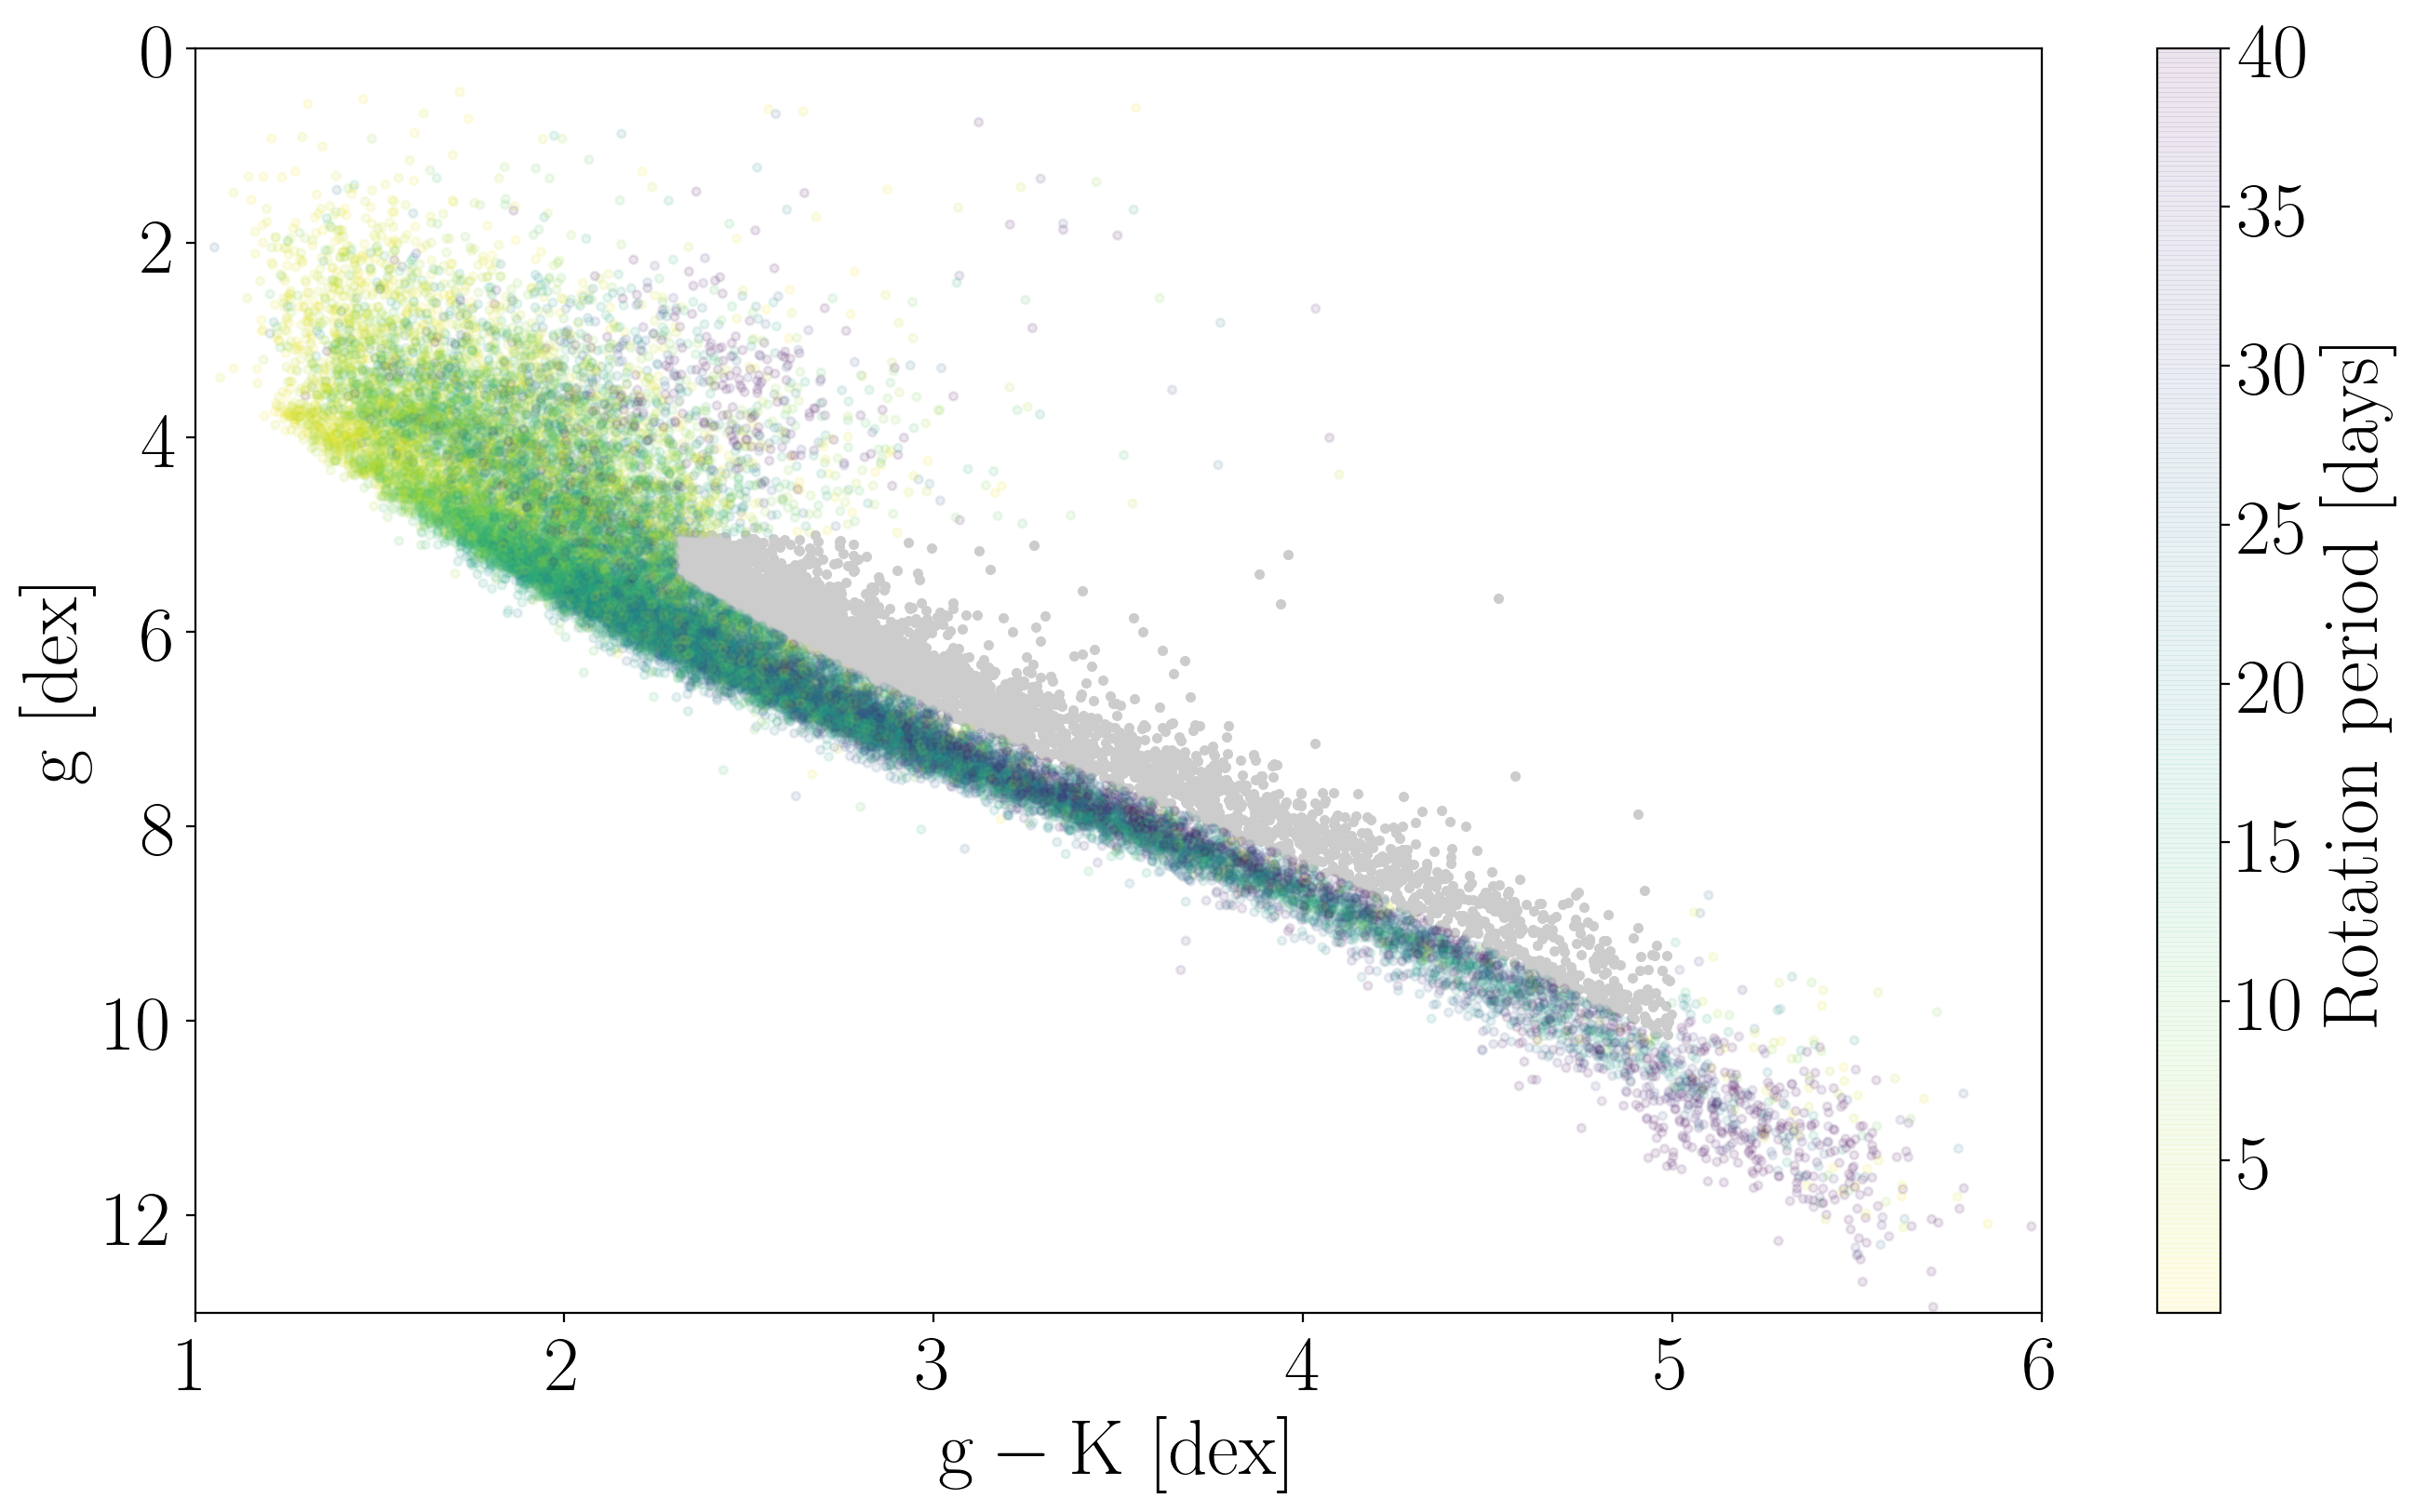

In [56]:
m = (minb < x) * (x < maxb)
m &= (y < np.polyval(w, x) - extra) * (5 < y)

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(df_finite.g_final[m] - df_finite.Kmag[m], 
         mM(df_finite.g_final[m], 1./df_finite.plx[m]),
         ".", c=".8", zorder=0)
plt.scatter(df_finite.g_final[~m] - df_finite.Kmag[~m],
            mM(df_finite.g_final[~m], 1./df_finite.plx[~m]),
            c=df_finite.Prot[~m], s=10, alpha=.1, cmap="viridis_r", vmax=40, zorder=1)
plt.xlabel("$\mathrm{g-K~[dex]}$")
plt.ylabel("$\mathrm{g~[dex]}$")
plt.colorbar(label="$\mathrm{Rotation~period~[days]}$")
plt.ylim(13, 0)
plt.xlim(1, 6);

In [69]:
df = df_finite.iloc[~m]

In [70]:
df.keys()

Index(['KIC', 'source_id', 'plx', 'plxe', 'g_final', 'g_final_err',
       'g_prov_final', 'r_final', 'r_final_err', 'r_prov_final', 'Jmag',
       'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag', '[Fe/H]i', 'n_[Fe/H]i',
       '_RA', '_DE', 'KID', 'Teff', 'logg', 'Mass', 'Prot', 'Prot_err', 'Rper',
       'LPH', 'w', 'DC', 'Flag', 'Av_flags', 'Av', 'Av_errp', 'Av_errm'],
      dtype='object')

Let's try running stardate on one of these stars.

In [71]:
import stardate as sd

Only use metallicities if they're spectroscopic.

In [80]:
i = 0
if df["n_[Fe/H]i"].values[i] == "SPE":
    iso_params = {"g": (df.g_final.values[i], df.g_final_err.values[i]),
                  "r": (df.r_final.values[i], df.r_final_err.values[i]),
                  "J": (df.Jmag.values[i], df.e_Jmag.values[i]),
                  "H": (df.Hmag.values[i], df.e_Hmag.values[i]),
                  "K": (df.Kmag.values[i], df.e_Kmag.values[i]),
                  "feh": (df["[Fe/H]i"].values[i], .05),
                  "parallax": (df.plx[i].values*1e3, df.plxe.values[i]*1e3)}
else:
    iso_params = {"g": (df.g_final.values[i], df.g_final_err.values[i]),
                  "r": (df.r_final.values[i], df.r_final_err.values[i]),
                  "J": (df.Jmag.values[i], df.e_Jmag.values[i]),
                  "H": (df.Hmag.values[i], df.e_Hmag.values[i]),
                  "K": (df.Kmag.values[i], df.e_Kmag.values[i]),
                  "parallax": (df.plx.values[i]*1e3, df.plxe.values[i]*1e3)}
    
print(iso_params)
print(df.Prot.values[i])
print(df.Av.values[i], df.Av_errm.values[i])

prot, prot_err = df.Prot.values[i], df.Prot.values[i]*.05
star = sd.Star(iso_params, prot=prot, prot_err=prot_err,
               Av=df.Av.values[i], Av_err=df.Av_errp.values[i],
               savedir="posteriors", filename="test")

{'g': (16.377020979, 0.0204564496077), 'r': (15.737160839200001, 0.020186852314799997), 'J': (14.507, 0.027000000000000003), 'H': (14.235999999999999, 0.038), 'K': (14.248, 0.063), 'parallax': (0.7168, 0.039)}
17.45
0.2741999836564064 0.0


In [73]:
star.fit(max_n=10000, thin_by=100)

/anaconda3/lib/python3.7/site-packages/isochrones-2.0.0-py3.7.egg/isochrones/priors.py:234: RuntimeWarning: divide by zero encountered in double_scalars
  a, b = (lo - mean) / sigma, (hi - mean) / sigma
/anaconda3/lib/python3.7/site-packages/isochrones-2.0.0-py3.7.egg/isochrones/priors.py:247: RuntimeWarning: divide by zero encountered in double_scalars
  return _norm_logpdf((x - self.mean) / self.sigma) - np.log(self.sigma) - self.lognorm
/anaconda3/lib/python3.7/site-packages/isochrones-2.0.0-py3.7.egg/isochrones/priors.py:247: RuntimeWarning: divide by zero encountered in log
  return _norm_logpdf((x - self.mean) / self.sigma) - np.log(self.sigma) - self.lognorm
/anaconda3/lib/python3.7/site-packages/isochrones-2.0.0-py3.7.egg/isochrones/priors.py:247: RuntimeWarning: invalid value encountered in double_scalars
  return _norm_logpdf((x - self.mean) / self.sigma) - np.log(self.sigma) - self.lognorm
100%|██████████| 10000/10000 [00:19<00:00, 521.98it/s]


In [74]:
from stardate import load_samples, read_samples

# Load the samples.
flatsamples, samples, prior_samples, posterior_samples = load_samples("posteriors/test.h5", burnin=20)

# Extract the median and maximum likelihood parameter estimates from the samples.
results = read_samples(flatsamples)

# Print the results as a pandas dataframe.
results

,EEP_med,EEP_errm,EEP_errp,EEP_std,EEP_ml,age_med_gyr,age_errm,age_errp,age_std,age_ml_gyr,...,distance_errm,distance_errp,distance_std_pc,distance_ml,Av_med,Av_errm,Av_errp,Av_std,Av_ml,index
0,329.579977,0.000118,0.0001,0.000095,329.58005,3.62719,0.000772,0.000864,0.000724,3.626983,...,0.017699,0.027123,0.025168,259.999069,0.004499,0.000079,0.000076,0.000091,0.00453,0


In [75]:
import corner

labels = ["EEP", "log(Age [yr])", "[Fe/H]", "ln(Distance)", "A_v", "ln(probability)"]

corner.corner(flatsamples, labels=labels);

ValueError: It looks like the parameter(s) in column(s) 5 have no dynamic range. Please provide a `range` argument.